In [ ]:
%load_ext autoreload
%autoreload 2
from scaleagdata_vito.presto.datasets_prometheo import ScaleAgInferenceDataset
from pathlib import Path
import xarray as xr
from prometheo.models.presto.wrapper import PretrainedPrestoWrapper, load_pretrained
from prometheo.predictors import collate_fn
from scaleagdata_vito.presto.datasets_prometheo import InferenceDataset
from typing import Literal
import torch
from torch.utils.data import DataLoader
from einops import rearrange
import numpy as np

### test

In [ ]:
path_to_file = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc')
cl = ScaleAgInferenceDataset(compositing_window="month")
s1, s2, meteo, dem, latlon, timestamps = cl.nc_to_array(path_to_file)
s1.shape, s2.shape, meteo.shape, dem.shape, latlon.shape, timestamps.shape

In [ ]:
class PrestoPredictor:
    def __init__(self,
                model: PretrainedPrestoWrapper, 
                batch_size: int = 8192,
                task_type: Literal["regression", "binary", "multiclass"] = "regression",
                compositing_window: Literal["dekad", "month"] = "dekad"):
        """
        Initialize the PrestoFeatureExtractor with a Presto model.

        Args:
            model (Presto): The Presto model used for feature extraction.
            batch_size (int): Batch size for dataloader.
        """
        self.model = model.to(device="cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.task_type = task_type
        self.compositing_window = compositing_window

    def predict(self, path_to_file: Path) -> xr.DataArray:
        cl = ScaleAgInferenceDataset(compositing_window=self.compositing_window)
        s1_cube, s2_cube, meteo_cube, dem_cube, latlon_cube, timestamps_cube = cl.nc_to_array(path_to_file)
        ds = InferenceDataset(s1_cube, 
                              s2_cube,
                              meteo_cube,
                              dem_cube,
                              latlon_cube, 
                              timestamps_cube)
        dl = DataLoader(
            ds, 
            batch_size=self.batch_size, 
            shuffle=False, 
            collate_fn=collate_fn
        )

        all_preds, all_probs = [], []
        self.model.eval()
        for batch in dl:
            with torch.no_grad():
                output = self.model(batch, inference=True)
                # binary classification
                if self.task_type == "binary":
                    probs = torch.sigmoid(output).cpu().numpy() 
                    preds = probs > 0.5                     
                # multiclass classification
                elif self.task_type == "multiclass":
                    probs = torch.softmax(output, dim=-1).cpu().numpy()
                    preds = probs.argmax(dim=-1)
                
                all_preds.append(preds.flatten())
                all_probs.append(probs.flatten())
        
        # need to be reshaped 
        all_preds = np.concatenate(all_preds)
        all_probs = np.concatenate(all_probs)
        return all_preds, all_probs

In [ ]:
# presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct_cropland_CROPLAND2_30D_random_time-token%3Dnone_balance%3DTrue_augment%3DTrue.pt"
# presto_url = "/home/giorgia/Private/git/scaleag-vito/presto-prometheo-binary-CROPLAND2-timeexplicit=False-run=202504161049.pt"
task_type = "binary" # "regression", "binary", "multiclass"
num_outputs = 14
if task_type == "regression":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=True)
elif task_type == "binary":
    # finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False) #, pretrained_model_path=presto_url)
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False, pretrained_model_path=presto_url)
elif task_type == "multiclass":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=num_outputs, regression=False)

# finetuned_model = load_pretrained( finetuned_model, presto_url) # here strict is True 
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    compositing_window="month",
)

In [ ]:
path_to_file = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc')
preds, probs = presto_model.predict(path_to_file)

In [ ]:
path_to_file_target = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_cropland_classification.nc')
target_arr = xr.open_dataarray(path_to_file_target).astype('uint16')
target_pred = target_arr.sel(bands='classification').data
target_probs = target_arr.sel(bands='probability_cropland').data
input_arr = xr.load_dataset(path_to_file)
x_coords = input_arr.x.values
y_coords = input_arr.y.values
preds_map = rearrange(preds, '(y x) -> y x', y=len(y_coords), x=len(x_coords))
prob_map = rearrange(probs, '(y x) -> y x', y=len(y_coords), x=len(x_coords))
bands = ['S2-L2A-B04', 'S2-L2A-B03', 'S2-L2A-B02']
rgb = np.stack([input_arr[band].values for band in bands], axis=-1)

In [ ]:
def min_max_normalize(image):
    # Ensure the input is a numpy array
    image = np.array(image, dtype=np.float32)
    
    # Compute the minimum and maximum values for the entire image
    min_val = image.min()
    max_val = image.max()
    
    # Perform min-max normalization
    normalized_image = (image - min_val) / (max_val - min_val)
    
    return normalized_image

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
i = 5
# Plot the B2 band
axs[0].imshow(min_max_normalize(rgb[i]))
axs[0].set_title('B2 Band')

# Plot the target_arr
axs[1].imshow(target_pred, cmap='viridis')
axs[1].set_title('Target Array')

# Plot the preds_map
axs[2].imshow(preds_map, cmap='viridis')
axs[2].set_title('Predictions Map')

# Plot the preds_map
axs[3].imshow(target_probs, cmap='viridis')
axs[3].set_title('Target Prob Map')

# Plot the prob_map
axs[4].imshow(prob_map, cmap='viridis')
axs[4].set_title('Probability Map')
cbar = fig.colorbar(axs[4].images[0], ax=axs[4], fraction=0.046, pad=0.04)
cbar.set_ticks([0, 1])
cbar.set_label('Probability')
plt.tight_layout()

### Pipeline

In [7]:
%load_ext autoreload
%autoreload 2
from scaleagdata_vito.presto.inference import PrestoPredictor, reshape_result, plot_results
from scaleagdata_vito.utils.map import ui_map
from scaleagdata_vito.utils.dateslider import date_slider

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Select Area of Interest

In [9]:
map = ui_map(area_limit=7)

In [10]:
spatial_extent = map.get_extent()

Select Temporal extent

In [11]:
# select 1 year of data
slider = date_slider()

In [12]:
temporal_extent = slider.get_processing_period()

2025-04-17 14:48:14.649 | INFO     | scaleagdata_vito.utils.dateslider:get_processing_period:187 - Selected processing period: 2021-01-01 to 2021-12-31


In [29]:
%load_ext autoreload
%autoreload 2
from scaleagdata_vito.openeo.extract_sample_scaleag import collect_inputs_for_inference

collect_inputs_for_inference(
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    output_path=Path('/home/giorgia/Private/scaleag_data_test/inference_extraction_test/'),
    composite_window="month",
)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Authenticated using refresh token.


2025-04-17 15:31:54,022 - openeo_gfmap.utils - INFO - Selected orbit state: DESCENDING. Reason: Orbit has more cumulative intersected area. 0.2962802672950452 > 0.1642523484550494


0:00:00 Job 'j-2504171331544ba09963ecb6d95bb305': send 'start'
0:00:13 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:00:19 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:00:25 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:00:33 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:00:43 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:00:55 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:01:11 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:01:30 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:01:54 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:02:24 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:03:02 Job 'j-2504171331544ba09963ecb6d95bb305': queued (progress 0%)
0:03:48 Job 'j-2504171331544ba09963ecb6d95bb305': running (progress N/A)
0:04:47 Job 'j-2504171331544ba09963ecb6d95bb305': running (progress N/A)
0:05:47 Jo

In [39]:
path_to_input_file = Path('/home/giorgia/Private/scaleag_data_test/inference_extraction_test/openEO.nc')
# inarr = xr.open_dataset(fp)
# # epsg = CRS.from_wkt(inarr.crs.attrs["crs_wkt"]).to_epsg()
# inarr = (
#     inarr
#     .to_array(dim="bands")
#     .drop_sel(bands="crs")
# )
# inarr


In [37]:

# presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct_cropland_CROPLAND2_30D_random_time-token%3Dnone_balance%3DTrue_augment%3DTrue.pt"
# presto_url = "/home/giorgia/Private/git/scaleag-vito/presto-prometheo-binary-CROPLAND2-timeexplicit=False-run=202504161049.pt"
task_type = "binary" # "regression", "binary", "multiclass"
num_outputs = 14
if task_type == "regression":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=True)
elif task_type == "binary":
    # finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False) #, pretrained_model_path=presto_url)
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False, pretrained_model_path=presto_url)
elif task_type == "multiclass":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=num_outputs, regression=False)

# finetuned_model = load_pretrained( finetuned_model, presto_url) # here strict is True 
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    compositing_window="month",
)

In [38]:
# path_to_input_file = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc')
probs = presto_model.predict(path_to_input_file)
prob_map = reshape_result(probs, path_to_input_file=path_to_input_file)
pred_map = presto_model.get_predictions(prob_map, threshold=0.5)
# probs.min(), probs.max(), 

/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/prometheo/models/presto/wrapper.py:114: RuntimeWarning: invalid value encountered in divide
  (band_1_np - band_2_np) / (band_1_np + band_2_np),
/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/prometheo/models/presto/wrapper.py:114: RuntimeWarning: invalid value encountered in divide
  (band_1_np - band_2_np) / (band_1_np + band_2_np),
/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/prometheo/models/presto/wrapper.py:114: RuntimeWarning: invalid value encountered in divide
  (band_1_np - band_2_np) / (band_1_np + band_2_np),
/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/prometheo/models/presto/wrapper.py:114: RuntimeWarning: invalid value encountered in divide
  (band_1_np - band_2_np) / (band_1_np + band_2_np),


/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


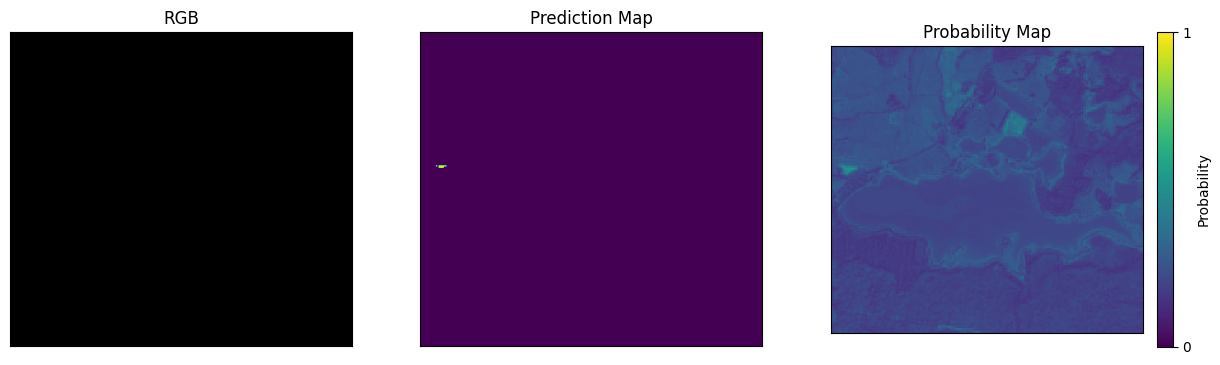

In [40]:
plot_results(prob_map=prob_map, pred_map=pred_map, path_to_input_file=path_to_input_file, ts_index=5)